# Sistema de recomendación para E-Commerce


## Librerias

In [139]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds 
from sklearn.model_selection import train_test_split


## Dataset

In [140]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current Working Directory:", current_directory)


Current Working Directory: c:\Users\alejo\UCEMA\Analitica avanzada\trabajo final\notebooks adicionales


In [141]:
data = pd.read_csv(r'..\data\ratings.csv')
data.drop(columns='Unnamed: 0', inplace=True)
data.head()

,user_id,prod_id,rating
0,A3BY5KCNQZXV5U,0594451647,5.0
1,AT09WGFUM934H,0594481813,3.0
2,A32HSNCNPRUMTR,0970407998,1.0
3,A17HMM1M7T9PJ1,0970407998,4.0
4,A3CLWR1UUZT6TG,0972683275,5.0


In [142]:
# Crear diccionarios de mapeo para user_id y prod_id
#user_id_mapping = {user_id: idx for idx, user_id in enumerate(df_copy['user_id'].unique())}
#prod_id_mapping = {prod_id: idx for idx, prod_id in enumerate(df_copy['prod_id'].unique())}
#
## Aplicar mapeo a las columnas user_id y prod_id
#df_copy['user_id'] = df_copy['user_id'].map(user_id_mapping)
#df_copy['prod_id'] = df_copy['prod_id'].map(prod_id_mapping)
#df_copy = df_copy.sample(20000)
## Guardar el DataFrame resultante en un nuevo archivo CSV
#df_copy.to_csv('nuevo_archivo.csv', index=False)


In [143]:
data.shape


(125871, 3)

In [144]:
data.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

In [145]:
data.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

### Usuarios unicos y productos unicos

In [146]:
print('Usuarios unicos= ', data['user_id'].nunique())
print('Productos unicos = ', data['prod_id'].nunique())

Usuarios unicos=  1540
Productos unicos =  48190


### Usuarios que mas reviews dejaron 

In [147]:
# Top 10 
mas_ratearon = data.groupby('user_id').size().sort_values(ascending=False)[:10]
mas_ratearon

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
dtype: int64

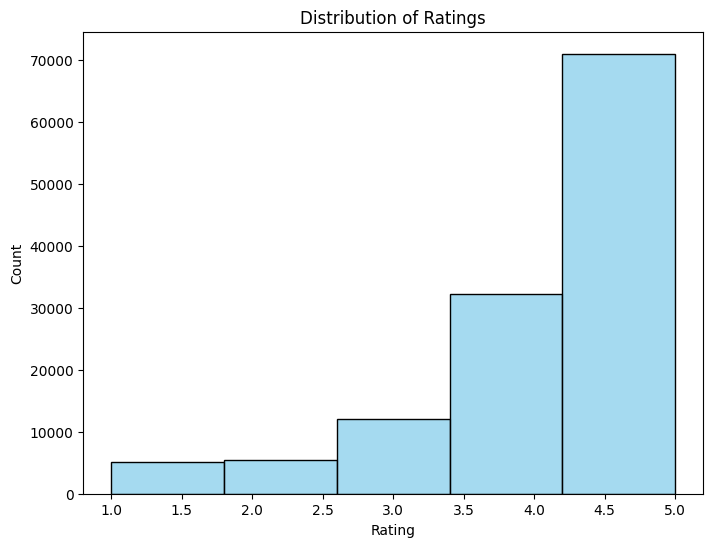

In [148]:
plt.figure(figsize=(8, 6))
sns.histplot(data['rating'], bins=5, kde=False, color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


## Pre-procesamiento

Voy a recortar el dataset, dejando unicamente aquellos usuarios con más de 50 ratings. De esta manera el set de datos será más parejo y rico para trabajar.

In [149]:
usuarios_counts = data['user_id'].value_counts()

In [150]:
data.shape

(125871, 3)

In [151]:
print('Filas =', len(data))
print('Nro de usuarios unicos = ', data['user_id'].nunique())
print('Nro de productos unicos = ', data['prod_id'].nunique())

Filas = 125871
Nro de usuarios unicos =  1540
Nro de productos unicos =  48190


# Recomendación por productos calientes (muy vendidos/recomendados)

In [152]:
# Rating pormedio por producto
average_rating = data.groupby('prod_id').mean()['rating']

# Cantidad de ratings por producto
count_rating = data.groupby('prod_id').count()['rating']

final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
0594451647,5.0,1
B003RRY9RS,5.0,1
B003RR95Q8,5.0,1
B003RIPMZU,5.0,1
B003RFRNYQ,5.0,2


In [153]:
# traer los top_n productos con cierto nivel minimo de interacciones 
def top_n_products(final_rating, top_n, interacciones_minimas):

    recommendaciones = final_rating[final_rating['rating_count']>interacciones_minimas]

    # ordenar los rdos
    recommendaciones = recommendaciones.sort_values('avg_rating',ascending=False)

    return recommendaciones.index[:top_n]

## Recomendar los 5 productos con mejor calificacion y mas de 50 interacciones

In [154]:
top_n_products(final_rating, 5, 50)

Index(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'], dtype='object', name='prod_id')

In [155]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

In [156]:
for i in list(top_n_products(final_rating, 5, 50)):
    print(i)
    print(final_rating.loc[final_rating.index == i, ['avg_rating']].values[0])
    print(final_rating.loc[final_rating.index == i, ['rating_count']].values[0])

B001TH7GUU
[4.87179487]
[78]
B003ES5ZUU
[4.86413043]
[184]
B0019EHU8G
[4.85555556]
[90]
B006W8U2MU
[4.8245614]
[57]
B000QUUFRW
[4.80952381]
[84]


## Recomendar los 5 productos con mejor calificacion y mas de 100 interacciones

In [157]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

# Recomendación por Collaborative Filtering

Se basa en la suposición de que a las personas les gustan cosas similares a otras cosas que les gustan, y cosas que son apreciadas por otras personas con gustos similares. Principalmente, existen dos tipos: a) Usuario-Usuario b) Ítem-Ítem.

### Matriz de ratings (usuarios x producto)

Se crea una matriz cruzando productos y usuarios, teniendo como valores los ratings que cada usuario le dio a cada producto. 

Se calcula para determinar la densidad de valores no vacíos en la matriz.

La densidad proporciona una medida de qué tan completa está la matriz en términos de valores no vacíos en comparación con su capacidad total.

In [158]:
# Creo la matriz y relleno con 0 los nulos
matriz_ratings_final = data.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape primera matriz: ', matriz_ratings_final.shape)

# Cuantos valores no vacios (0) en la matriz
numeros_ratings = np.count_nonzero(matriz_ratings_final)
print('Numero de ratings no vacios = ', numeros_ratings)

# espacios de la matriz
num_de_ratings_posibles = matriz_ratings_final.shape[0] * matriz_ratings_final.shape[1]
print('Espacios totales de la matriz = ', num_de_ratings_posibles)

# Densidad 
density = (numeros_ratings/num_de_ratings_posibles)
density *= 100
print ('Densidad = {:4.2f}%'.format(density))

matriz_ratings_final.head()

Shape primera matriz:  (1540, 48190)
Numero de ratings no vacios =  125871
Espacios totales de la matriz =  74212600
Densidad = 0.17%


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Tenemos una matriz con muy pocos valores distintos a 0 (menos de 1% de toda la matriz)

## Basado en usuarios

Como user_id es tipo de dato object, voy a remplazarlo por un indice numerico para que sea integer. 

In [159]:
matriz_ratings_final['user_index'] = np.arange(0, matriz_ratings_final.shape[0])
matriz_ratings_final.set_index(['user_index'], inplace=True)

# Matriz con indice
matriz_ratings_final.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Encontrar usuarios similares en base al score de similitud

In [160]:
data.columns

Index(['user_id', 'prod_id', 'rating'], dtype='object')

In [161]:
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): 

        # le pasamos un usuarioid y buscamos la similitud con el resto
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])

        # guardo los rdos en formato tupla dentro de una lista
        similarity.append((user,sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #extraer el usuario de la tupla
    similarity_score = [tup[1] for tup in similarity] # extraer el score de similitud

    # quito de la lista el mismo usuario que busque
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

In [162]:
def similar_users(user_index, interactions_matrix):
    similarity = []

    for user in range(interactions_matrix.shape[0]):
        # le pasamos un usuarioid y buscamos la similitud con el resto
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])[0][0]

        # guardo los rdos en formato tupla dentro de una lista
        similarity.append((user, sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    
    # Extract user index and similarity score from the sorted list
    most_similar_users = [tup[0] for tup in similarity]#extraer el usuario de la tupla
    similarity_score = [tup[1] for tup in similarity]# extraer el score de similitud

    # quito de la lista el mismo usuario que busque
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    # Guardo en data
    result_df = pd.DataFrame({'UserIndex': most_similar_users, 'SimilarityScore': similarity_score})

    return result_df

#### Top 10 usuarios por similitud

In [163]:
# Usuarios similares al usuario 3
similar = similar_users(3,matriz_ratings_final)
similar.head(10)

,UserIndex,SimilarityScore
0,320,0.056624
1,12,0.055496
2,793,0.050983
3,261,0.050242
4,156,0.050039
5,1493,0.049301
6,1250,0.048894
7,567,0.046727
8,753,0.046373
9,1360,0.044927


In [164]:
similar.iloc[0]

UserIndex          320.000000
SimilarityScore      0.056624
Name: 0, dtype: float64

### Funcion de recomendacion de productos

In [165]:
#Usando los resultados de similitud de usuario creamos una funcion de recomendacion de productos
def recommendations(user_index, num_of_products, interactions_matrix):

    # Uso la funcion de usuarios similares, tomo el primero
    most_similar_users = similar_users(user_index, interactions_matrix).loc[0]

    # Busco los productos del usuario similar
    product_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = product_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            # Busco productos rateados por el usuario similar pero no por el user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

#### Recomendar 5 productos al usuario 3 basado en similitud 

In [166]:
recommendations(350,5,matriz_ratings_final)

['B008ULPAT2', 'B002TOJXNU', 'B007W7PIZ6', 'B003GAMO78', 'B00DQZSBUC']

#### Recommend 5 products to user index 1521 based on similarity based collaborative filtering

In [167]:
recommendations(1521,5,matriz_ratings_final)

['B0040XQ7PK', 'B00F1CRTLK', 'B004MF11MU', 'B002L6GEKG', 'B004SNCZ3K']

# Model based Collaborative Filtering: Singular Value Decomposition

In [168]:
# Dividir los datos en train y test
train_data, test_data = train_test_split(matriz_ratings_final, test_size=0.2, random_state=42)

## CSR matrix

In [169]:
from scipy.sparse import csr_matrix
#final_ratings_sparse = csr_matrix(matriz_ratings_final.values)
train_data_sparse = csr_matrix(train_data.values)
test_data_sparse = csr_matrix(test_data.values)


La función csr_matrix toma como entrada una matriz y la convierte en una representación comprimida, que es eficiente en términos de almacenamiento para matrices dispersas con muchos elementos cero.


## SVD

In [170]:
# Singular Value Decomposition
#U, s, Vt = svds(final_ratings_sparse, k = 50) # k es el numero de features latentes
# construir un array diagonal en SVD
#sigma = np.diag(s)
U, s, Vt = svds(train_data_sparse, k=50)
sigma = np.diag(s)


Esta descomposición factoriza la matriz en tres matrices: U (matriz izquierda), s (vector de valores singulares) y Vt (matriz derecha transpuesta). El parámetro k especifica el número de valores singulares (o características latentes) que se deben calcular. En este caso, se ha fijado en 50.

Crea una matriz diagonal sigma a partir del vector de valores singulares s. La función np.diag de NumPy toma un vector y lo coloca en una matriz diagonal. En este contexto, sigma se utiliza para representar la matriz diagonal de valores singulares en la descomposición SVD.

 Este proceso es comúnmente utilizado en técnicas de factorización de matrices para encontrar representaciones latentes de los datos, especialmente en el contexto de sistemas de recomendación.

## Predecir ratings

Regeneramos la matriz original usando U, Sigma, y Vt. La matriz resultado sera la prediccion de los ratings de cada usuario para todos los productos

In [176]:
users_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Ratings predichos
#preds_df = pd.DataFrame(abs(users_predicted_ratings), columns = matriz_ratings_final.columns)
preds_df = pd.DataFrame(abs(users_predicted_ratings), columns = train_data.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

## Funcion para recomendar productos

In [177]:
def recommend_items(user_index, interactions_matrix, preds_matrix):

    # Tomo ratings reales y predichos de las matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    # Creo un df con ratings reales y predichos en columnas
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')

    # Filtro ese data donde los ratings reales son 0, es decir donde el usuario no interactuo con ese producto
    temp = temp.loc[temp.user_ratings == 0]

    # Recomendando en base a la prediccion de los productos mejor rankeados para un usuario
    temp = temp.sort_values('user_predictions',ascending=False) # ordenar por prediccion descendiente 
    return temp


### Recomendar top 5 productos al user id 121

In [178]:
# Ingreso 'user index' y 'num_recommendations' para el usuario
recommend_items(121,train_data_sparse,preds_matrix)

,user_ratings,user_predictions
Recommended Products,,
39338,0.0,1.293506
28763,0.0,1.073510
28761,0.0,1.050205
38655,0.0,0.991431
22210,0.0,0.839918
...,...,...
17728,0.0,0.000000
17732,0.0,0.000000
40370,0.0,0.000000


## Evaluacion del modelo

In [179]:
#matriz_ratings_final['user_index'] = np.arange(0, matriz_ratings_final.shape[0])
#matriz_ratings_final.set_index(['user_index'], inplace=True)
train_data['user_index'] = np.arange(0, train_data.shape[0])
train_data.set_index(['user_index'], inplace=True)

# Ratings reales
train_data.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
# ratings promedio
average_rating = train_data.mean()
average_rating.head()

prod_id
0594451647    0.004058
0594481813    0.002435
0970407998    0.004058
0972683275    0.015422
1400501466    0.012175
dtype: float64

In [181]:
# ratings predichos
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.001483,0.004107,0.006176,0.179612,0.012500,1.894005e-16,0.001616,0.016261,0.007005,0.001347,...,0.002330,0.015878,0.001281,0.028242,0.0,0.0,0.001360,0.196687,0.084076,0.050855
1,0.005807,0.022938,0.039278,0.009074,0.000910,2.689589e-16,0.026010,0.008172,0.006610,0.000047,...,0.001048,0.175556,0.001860,0.144511,0.0,0.0,0.017113,0.011584,0.032672,0.009256
2,0.000139,0.004765,0.009103,0.039498,0.004579,4.224950e-16,0.016255,0.002707,0.004177,0.000654,...,0.001690,0.002739,0.000974,0.044938,0.0,0.0,0.004419,0.100610,0.083672,0.020887
3,0.006732,0.001996,0.058562,0.031843,0.001678,1.198487e-16,0.003703,0.000645,0.010957,0.000289,...,0.002566,0.062007,0.002099,0.053148,0.0,0.0,0.005487,0.075371,0.046294,0.072152
4,0.000329,0.004378,0.001061,0.008362,0.004026,4.906841e-18,0.002083,0.000879,0.014061,0.000280,...,0.000177,0.011014,0.000109,0.005719,0.0,0.0,0.002894,0.010199,0.004880,0.006831


In [182]:
# promedios de ratings predichos
avg_preds=preds_df.mean()
avg_preds.head()

prod_id
0594451647    0.003961
0594481813    0.007174
0970407998    0.015066
0972683275    0.047303
1400501466    0.006315
dtype: float64

In [183]:
# voy a comparar los promedios entre lo predicho y lo real para calcular el error
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
prod_id,,
0594451647,0.004058,0.003961
0594481813,0.002435,0.007174
0970407998,0.004058,0.015066
0972683275,0.015422,0.047303
1400501466,0.012175,0.006315


calcular el error cuadrático medio entre las calificaciones reales (Avg_actual_ratings) y las calificaciones predichas (Avg_predicted_ratings). El parámetro squared=False se utiliza para obtener la raíz cuadrada del error cuadrático medio en lugar del error cuadrático medio sin la raíz cuadrada.

In [186]:

RMSE= mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
# Predicciones para conjunto de prueba
test_users_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# predicciones a DataFrame
test_preds_df = pd.DataFrame(abs(test_users_predicted_ratings), columns=test_data.columns)

# RMSE para el conjunto de prueba
test_rmse_df = pd.concat([test_data.mean(), test_preds_df.mean()], axis=1)
test_rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

test_RMSE = mean_squared_error(test_rmse_df['Avg_actual_ratings'], test_rmse_df['Avg_predicted_ratings'], squared=False)

print(f'RMSE SVD Model (Train)= {RMSE}')
print(f'RMSE SVD Model (Test) = {test_RMSE}')

RMSE SVD Model (Train)= 0.013815558039944767
RMSE SVD Model (Test) = 0.01906746425035344


Error Cuadrático Medio (MSE): El MSE es una medida que calcula el promedio de los cuadrados de las diferencias entre los valores reales y los valores predichos.

Raíz Cuadrada del Error Cuadrático Medio (RMSE): El RMSE es simplemente la raíz cuadrada del MSE.
 
El RMSE tiene la ventaja de estar en la misma escala que la variable de interés (en este caso, las calificaciones) y, por lo tanto, es más interpretable.

En el contexto de modelos de recomendación, el RMSE se utiliza para medir cuán bien las calificaciones predichas por el modelo coinciden con las calificaciones reales. Un valor más bajo de RMSE indica que el modelo tiene un mejor rendimiento en términos de predicciones precisas.

En resumen, el RMSE es una métrica que proporciona una medida cuantitativa de la precisión de un modelo al comparar las predicciones del modelo con los valores reales.